In [6]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs
import configs

device = 'cpu'

## Plot loss for one-hot features

In [14]:
experiment_dir = "/home/chingf/engram/Ching/03_td_baselines/onehot/0.95/"
steps = []
losses = []

for _iter in os.listdir(experiment_dir):
    iter_dir = experiment_dir + _iter + '/'
    if not os.path.isdir(iter_dir): continue
    for file in os.listdir(iter_dir):
        if 'tfevents' not in file: continue
        tfevents_file = iter_dir + '/' + file
        event_acc = EventAccumulator(tfevents_file)
        event_acc.Reload()
        scalar_events = event_acc.Scalars('loss_train')
        for i in range(len(scalar_events)):
            steps.append(scalar_events[i].step)
            losses.append(scalar_events[i].value)

steps = np.array(steps)/(60*configs.dt_to_sec)
losses = np.array(losses)

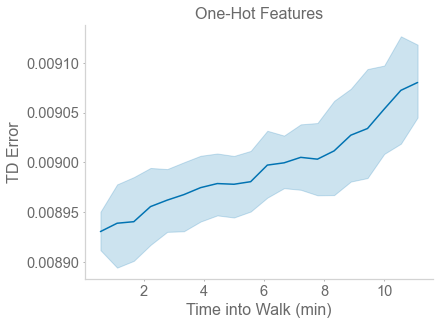

In [15]:
df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses})
fig, ax = plt.subplots(
    figsize=(6.4*1., 4.8*1.)
    ) # width, height
sns.lineplot(
    x='Steps into Walk', y='TD Error', data=df, ax=ax,
    hue_order=hue_order
    )
plt.xlabel('Time into Walk (min)')
plt.ylabel('TD Error')
plt.title('One-Hot Features')
plt.tight_layout()
plt.savefig('td_baseline_onehot.png', dpi=100)
plt.show()

# Look at M/T error

In [42]:
with open("/home/chingf/engram/Ching/03_td_baselines/onehot/results_0.4.p", 'rb') as f:
    results = pickle.load(f)

In [43]:
results.keys()

dict_keys(['T_error', 'M_error', 'T_row_norm', 'T_col_norm'])

In [44]:
t_error = results['T_error']
m_error = results['M_error']
t_row_norm = results['T_row_norm']
t_col_norm = results['T_col_norm']

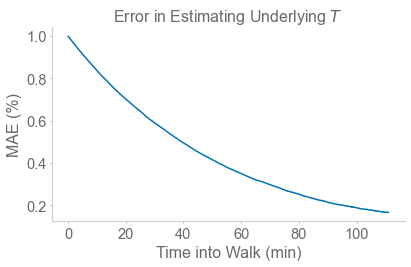

In [45]:
plt.figure()
errors = []
times = []
for _iter in range(len(m_error)):
    y = t_error[_iter]*100
    errors.extend(y)
    times.extend(np.arange(y.size)/configs.dt_to_sec/60)
df = pd.DataFrame({'errors': errors, 'times': times})

sns.lineplot(x='times', y='errors', data=df)
plt.title('Error in Estimating Underlying $T$')
plt.ylabel('MAE (%)')
plt.xlabel('Time into Walk (min)')
plt.tight_layout()
#plt.savefig('1f_oja_t_error.png', dpi=300)
plt.show()

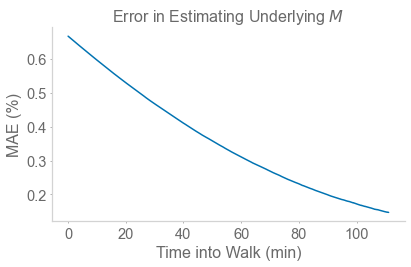

In [46]:
plt.figure()
errors = []
times = []
for _iter in range(len(m_error)):
    y = m_error[_iter]*100
    errors.extend(y)
    times.extend(np.arange(y.size)/configs.dt_to_sec/60)
df = pd.DataFrame({'errors': errors, 'times': times})

sns.lineplot(x='times', y='errors', data=df)
plt.title('Error in Estimating Underlying $M$')
plt.ylabel('MAE (%)')
plt.xlabel('Time into Walk (min)')
plt.tight_layout()
#plt.savefig('1f_oja_t_error.png', dpi=300)
plt.show()

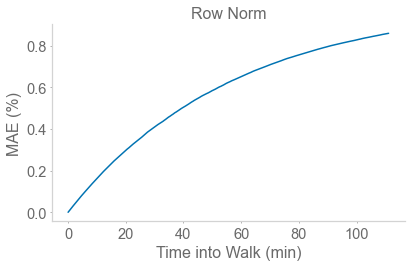

In [47]:
plt.figure()
errors = []
times = []
for _iter in range(len(m_error)):
    y = t_col_norm[_iter]
    errors.extend(y)
    times.extend(np.arange(y.size)/configs.dt_to_sec/60)
df = pd.DataFrame({'errors': errors, 'times': times})

sns.lineplot(x='times', y='errors', data=df)
plt.title('Row Norm')
plt.ylabel('MAE (%)')
plt.xlabel('Time into Walk (min)')
plt.tight_layout()
#plt.savefig('1f_oja_t_error.png', dpi=300)
plt.show()

# Visually compare learned M

In [50]:
experiment_dir = "/home/chingf/engram/Ching/03_td_baselines/onehot/0.95/"

for _iter in os.listdir(experiment_dir):
    if not os.path.isdir(f"{experiment_dir}{_iter}"): continue
    if _iter != '2': continue
    with open(f"{experiment_dir}{_iter}/results.p", 'rb') as f:
        results = pickle.load(f)
    rnn_T = results['rnn_T']
    rnn_M = results['rnn_M']
    dset = results['dset']
    true_T = dset.get_true_T()
    true_M = np.linalg.pinv(np.eye(true_T.shape[0]) - 0.4*true_T)
    rnn_M = np.linalg.pinv(np.eye(true_T.shape[0]) - 0.4*rnn_T.detach().numpy())

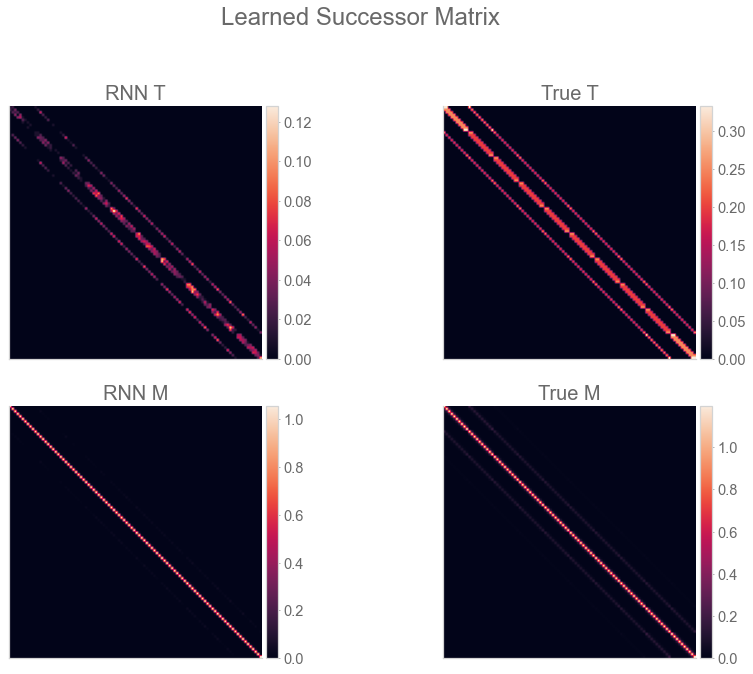

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))
axtitle_fontsize=20

# RNN Fixed LR
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,0].imshow(rnn_T.detach().numpy())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,0].set_title('RNN T', fontsize=axtitle_fontsize)

# RNN Dynamic LR
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,1].imshow(true_T)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,1].set_title('True T', fontsize=axtitle_fontsize)

# STDP RNN
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,0].imshow(rnn_M)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,0].set_title('RNN M', fontsize=axtitle_fontsize)

# Linear
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,1].imshow(true_M)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,1].set_title('True M', fontsize=axtitle_fontsize)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Learned Successor Matrix", fontsize=24)
plt.tight_layout(rect=[0, 0., 1, 0.95])
#plt.savefig('M_comparisons.png', dpi=150)
plt.show()